# EFASv5 - puntos de cálculo
***

***Autor:** Jesús Casado*<br>
***Fecha:** 08-09-2023*<br>

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import yaml
import geopandas as gpd
from shapely.geometry import Point
from tqdm.notebook import tqdm
import cartopy.crs as ccrs
import cartopy.feature as cf

from metricas_rendimiento import KGE, KGEmod, ECDF
from anuario_aforos import extraer_caudal_estaciones, extraer_caudal_embalses, plot_caudal

In [2]:
from pathlib import Path

## Configuración

In [3]:
with open("config.yml", "r", encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

In [4]:
# inicio y fin del periodo de estudio
start = cfg['periodo'].get('inicio', None)
end = cfg['periodo'].get('final', None)
start, end = [pd.to_datetime(i) for i in [start, end]]

In [5]:
# ruta donde se ubican los datos del Anurio de Aforos
path_anuario = Path(cfg['rutas']['anuario_aforos'])
path_efas = Path(cfg['rutas']['EFAS'])

In [6]:
# tamaño mínimo y máximo de la cuenca
# area_min = cfg['area'].get('min', 100) # km²
# area_max = cfg['area'].get('max', None) # km²

In [7]:
# # disponibilidad mínima de datos durante el periodo de estudio (tanto por uno)
# disponibilidad = cfg['seleccion'].get('disponibilidad', .9)
# min_años = cfg['seleccion'].get('n_años', .9)

In [8]:
# start = '1991-10-01'
# end = '2020-09-30'

## Capas
### Cuencas

In [9]:
# cargar polígono de las demarcaciones hidrográficas
cuencas = gpd.read_file('../../data/cartografia/hidrografia/demarcaciones.shp')
cuencas[['CUENCA_ID', 'COD_DEMAR']] = cuencas[['CUENCA_ID', 'COD_DEMAR']].astype(int)
cuencas.set_index('CUENCA_ID', drop=True, inplace=True)
cuencas = cuencas[~cuencas.COD_DEMAR.isin([101, 61, 111, 121, 122, 123, 124, 125, 126, 127, 150, 63, 64, 160])]
cuencas['pais'] = 'ES'

# disolver el polígono
area = cuencas.dissolve(by='pais')

### Puntos
#### EFASv5

In [10]:
# cargar datos
efas = pd.read_csv(path_efas / '../points/indexes_ltr_efasnext.csv', index_col='ObsID')

# filtrar y renombrar columnas
efas_cols = {'National_Station_Identifier': 'origID',
             'StationName': 'name',
             'Provider ID': 'provider',
             'Country code': 'country',
             'StationLon': 'lon',
             'StationLat': 'lat',
             'LisfloodX': 'LisfloodX',
             'LisfloodY': 'LisfloodY',
             'Height': 'Z',
             'River': 'river',
             'EC_Catchments': 'catchment',
             'DrainingArea.km2.Provider': 'area_provi',
             'DrainingArea.km2.LDD': 'area_ldd',
             'FixedRepPoint': 'RepPoint',
             'Notes': 'Notes',
             'EC_calib': 'EC_calib',
             'KGE': 'KGE',
             'KGE_r': 'KGE_r',
             'KGE_B': 'KGE_B',
             'KGE_y': 'KGE_y',}
efas = efas[efas_cols.keys()].rename(columns=efas_cols)

# estaciones en España
efas['country'] = efas['country'].str.upper()
efas = efas[efas['country'] == 'ES']

# mantener sólo puntos calibrados
efas = efas[efas.EC_calib >= 1]

In [11]:
# convertir en GeoPandas
# efas = gpd.GeoDataFrame(efas, geometry=[Point(xy) for xy in zip(efas['StationLon'], efas['StationLat'])])
efas = gpd.GeoDataFrame(efas, geometry=[Point(xy) for xy in zip(efas['lon'], efas['lat'])])
efas.crs = 'EPSG:4326'

# recortar a las cuencas de estudio
efas = gpd.clip(efas, area.geometry)

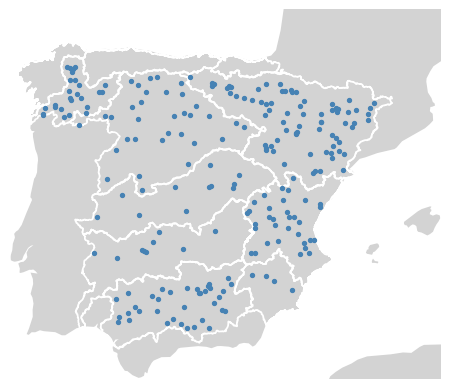

In [12]:
# plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
ax.scatter(efas.geometry.x, efas.geometry.y, c='steelblue', s=8, alpha=1);
ax.axis('off');
# fig.legend(frameon=False, bbox_to_anchor=[.8, .6, .225, .3]);

#### Anuario de aforos

In [13]:
# cargar estaciones del anuario de aforos
estaciones = gpd.read_file('../../data/anuario_aforos/GIS/estaciones.shp')
estaciones.set_index('indroea', drop=True, inplace=True)

In [14]:
# cargar embalses del Anuario de Aforos
embalses = gpd.read_file('../../data/anuario_aforos/GIS/embalses.shp')
embalses.set_index('ref_ceh', drop=True, inplace=True)
embalses = embalses.rename(index={cod: f'{cod}_E' for cod in embalses.index[~embalses.index.str.contains('_E')]})

#### Comparativa

El Anuario de Aforos tiene 1074 estaciones y 394 embalses


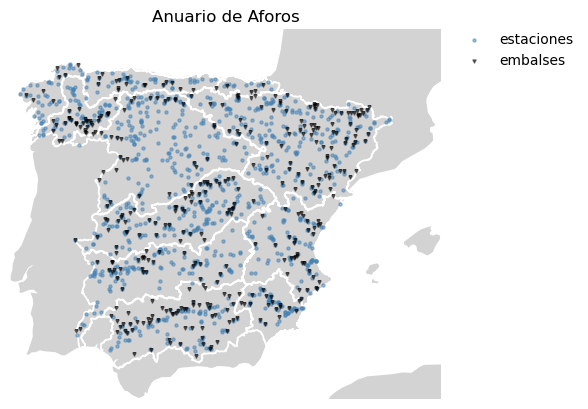

In [15]:
print(f'El Anuario de Aforos tiene {estaciones.shape[0]} estaciones y {embalses.shape[0]} embalses')
# print(f'EFASv5 tiene {efas.shape[0]} puntos')

# plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
cuencas.plot(ax=ax, facecolor='none', edgecolor='w', linewidth=1.2);
ax.scatter(estaciones.geometry.x, estaciones.geometry.y, c='steelblue', s=5, alpha=.5, label='estaciones')
ax.scatter(embalses.geometry.x, embalses.geometry.y, c='k', marker='v', s=5, alpha=.5, label='embalses')
# ax.scatter(efas.geometry.x, efas.geometry.y, c='maroon', s=5, alpha=.5, label='EFAS')
ax.axis('off')
ax.set_title('Anuario de Aforos')
fig.legend(frameon=False, bbox_to_anchor=[.85, .6, .225, .3]);

#### ID ROEA de los puntos EFAS

In [16]:
if ('indroea' not in efas.columns) & (efas.index.name != 'indroea'):

    # convertir en coordenadas projectadas para poder calcular distancias
    efas = efas.to_crs(25830)
    estaciones = estaciones.to_crs(25830)
    embalses = embalses.to_crs(25830)
    
    # se toma el ID del punto más cercano (mínimo 10000 m)
    dist_max = 1e4
    efas['indroea'] = np.nan
    for id in tqdm(efas.index):
        x, y = efas.loc[[id]].geometry.x, efas.loc[[id]].geometry.y
        # estación del Anuario más cercana al punto EFAS
        dist = estaciones.distance(Point(x, y))
        dist = dist[dist < dist_max]
        if dist.shape[0] > 0:
            efas.loc[id, 'indroea'] = dist.idxmin()
        # embalse del Anuario más cercano al punto EFAS
        else:
            dist = embalses.distance(Point(x, y))
            dist = dist[dist < dist_max]
            if dist.shape[0] > 0:
                efas.loc[id, 'indroea'] = dist.idxmin()
    
    # definir sistema de coordenadas
    efas = efas.to_crs(4326)
    
    # ubicar los puntos en sus coordenadas en LISFLOOD
    geometry = [Point(lon, lat) for lon, lat in zip(efas.LisfloodX, efas.LisfloodY)]
    efas = gpd.GeoDataFrame(efas, geometry=geometry)

    # exportar
    efas.to_file('../../data/EFASv5/reporting_points/reporting_points_performance_indroea.shp', index=True)
else:

    # importar capa corregida
    efas = gpd.read_file('../data/EFASv5/reporting_points/reporting_points_performance_indroea.shp')
    if ('ObsID' not in efas.columns) & (efas.index.name == 'ObsID'):
        efas['ObsID'] = efas.index
    efas.set_index('indroea', drop=True, inplace=True)

  0%|          | 0/226 [00:00<?, ?it/s]

## Caudal

### Observado

In [17]:
# cargar series completas de caudal
cuencas = [dir for dir in os.listdir(path_anuario) if os.path.isdir(os.path.join(path_anuario, dir))]
Qobs = pd.DataFrame(index=pd.date_range(start, end, freq='1d'), dtype=float)
for cuenca in tqdm(cuencas):
    Qstn = extraer_caudal_estaciones(path_anuario / cuenca / 'afliq.csv', start=start, end=end)
    Qmbl = extraer_caudal_embalses(path_anuario / cuenca / 'afliqe.csv', start=start, end=end)
    Qmbl.columns = [f'{cod}_E' for cod in Qmbl.columns]
    Qobs = pd.concat((Qobs, Qstn, Qmbl), axis=1)

print(f'nº de estaciones en las series de caudal:\t{Qobs.shape[1]}')
print(f'nº de estaciones en la tabla de atributos:\t{estaciones.shape[0]}')

  0%|          | 0/10 [00:00<?, ?it/s]

nº de estaciones en las series de caudal:	1430
nº de estaciones en la tabla de atributos:	1074


In [18]:
# extraer series de caudal observado para los puntos EFAS con ID del Anuario de Aforos
ids = Qobs.columns.intersection(efas.indroea)
Qobs = Qobs[ids]

print(f'nº de puntos EFAS en las series de caudal:\t{Qobs.shape[1]}')

nº de puntos EFAS en las series de caudal:	193


In [19]:
# hidrogramas
path_out = Path('hidrogramas/EFAS_puntos/')
if path_out.exists() is False:
    path_out.mkdir()
for stn in Qobs.columns:
    if stn in estaciones.index:
        cuenca = estaciones.loc[stn, 'cuenca']
        file = path_out / '{0}/{1:04}.jpg'.format(cuenca, stn)
        title = '{0} - {1} ({2} km2)'.format(stn, *estaciones.loc[stn, ['lugar', 'suprest']])
    elif stn in embalses.index:
        cuenca = embalses.loc[stn, 'cuenca']
        file = path_out / '{0}/{1:06}.jpg'.format(cuenca, stn)
        title = '{0} - {1}'.format(stn, *embalses.loc[stn, 'nombre'])
    path = path_out / cuenca
    if path.exists() is False:
        path.mkdir()
    plot_caudal(Qobs[stn], title=title, save=file)
    plt.close()

### Simulado

In [ ]:
# cargar caudal reanálisis
Qsim = xr.open_mfdataset('../../data/EFASv5/caudal/reporting_points/dis_*.nc', chunks='auto')['discharge']

# eliminar días duplicados
Qsim = Qsim.drop_duplicates('time', keep='last')

# mantener sólo las estaciones de EFAS con caudal observado
id = efas.loc[Qobs.columns, 'ObsID'].to_list()
Qsim = Qsim.sel(id=id, time=slice(start, end)).compute()

# convertir en pd.DataFrame
Qsim = Qsim.to_pandas()

# renombrar las columnas con su indroea
Qsim.rename(columns={efas_id: indroea for indroea, efas_id in zip(efas.index, efas.ObsID)}, inplace=True)

Qsim.head()

## Rendimiento EFASv5

In [ ]:
# calcular el coeficiente de eficiencia modificado de Kling-Gupta y sus componentes
rend= pd.DataFrame({id: KGEmod(Qobs[id], Qsim[id]) for id in Qobs.columns.intersection(Qsim.columns)},
                   index=['KGEmod', 'alpha', 'beta', 'r']).transpose()

In [ ]:
efas = pd.concat((efas, rend), axis=1)

In [ ]:
# plot subcuencas
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(subplot_kw={'projection': proj})
ax.add_feature(cf.NaturalEarthFeature('physical', 'land', '50m', edgecolor=None, facecolor='lightgray'), zorder=0)
ax.set_extent([-9.5, 3.5, 36, 44.5], crs=proj)
efas.plot(c=efas.KGEmod, cmap='coolwarm_r', edgecolor='k', lw=.3, markersize=10, ax=ax)
ax.set_title('EFAS - KGEmod')
ax.axis('off');

In [ ]:
ecdf_KGE = ECDF(efas.KGEmod, plot=True, title='EFASv5', ylabel='KGEmod (-)')